In [1]:
from UTILITY_quickstart import *

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
csrTF = False
evalElement = "PENT"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
)

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 10000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [4]:
tao.cmd("set beam add_saved_at = CN2069")

[]

In [5]:
def collimateBeam(
    P,
    allCollimatorRules = None             
):
    PMod = P.copy()


    for collimatorRange in allCollimatorRules:

        print(collimatorRange)
        all_indices = np.arange(len(PMod.x))
        killedIndices = np.where(np.logical_and(PMod.x > collimatorRange[0], PMod.x < collimatorRange[1]))[0]
        survivingIndices = np.setdiff1d(all_indices, killedIndices)
        
        # OpenPMD checks the length so I can't just remove the "killed" particles
        # Also, for compatibility, I don't want to change either the weight or status of the killed particles
        filtered_data = {
            "x": PMod.x[survivingIndices],
            "y": PMod.y[survivingIndices],
            "z": PMod.z[survivingIndices],
            "px": PMod.px[survivingIndices],
            "py": PMod.py[survivingIndices],
            "pz": PMod.pz[survivingIndices],
            "t": PMod.t[survivingIndices], 
            "status": PMod.status[survivingIndices], 
            "weight": PMod.weight[survivingIndices], 
            "species": PMod.species
        }
        
        # Create a new ParticleGroup instance with the filtered data
        PMod = ParticleGroup(data=filtered_data)
        print(f"New particle count: {len(PMod.x)}")
        print(f"{len(PMod.x)}")

    return PMod




Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting


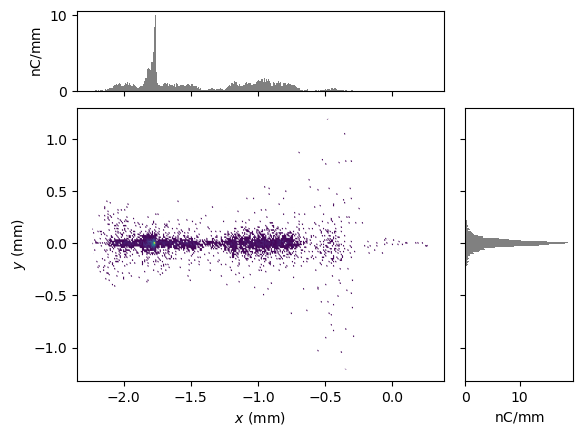

[-0.002, -0.0015]
New particle count: 5435
5435
[-0.0011, -0.001]
New particle count: 4753
4753
New particle count: 4753
4753


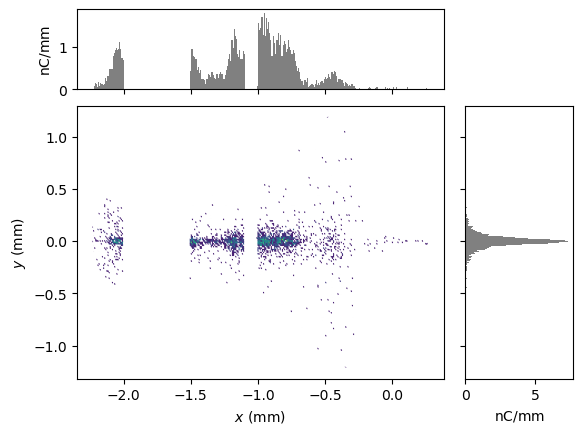

<Figure size 640x480 with 0 Axes>

In [6]:
comparisonElement = "CB2LE"

trackBeam(tao, trackEnd = "end", verbose = True, centerBC14=True, centerBC20=True)
P = getBeamAtElement(tao, "CN2069")
P_baseline_comparison = getBeamAtElement(tao, comparisonElement)

display(plotMod(P, 'x', 'y',  bins=300))

PCollimated = collimateBeam(P, allCollimatorRules = [[-0.002, -0.0015], [-0.0011, -0.001]] )

print(f"New particle count: {len(PCollimated.x)}")
print(f"{len(PCollimated.x)}")

display(plotMod(PCollimated, 'x', 'y',  bins=300))
plt.clf()

Loaded activeBeamFile.h5
Set track_start = CN2069, track_end = end
Tracking!
trackBeam() exiting


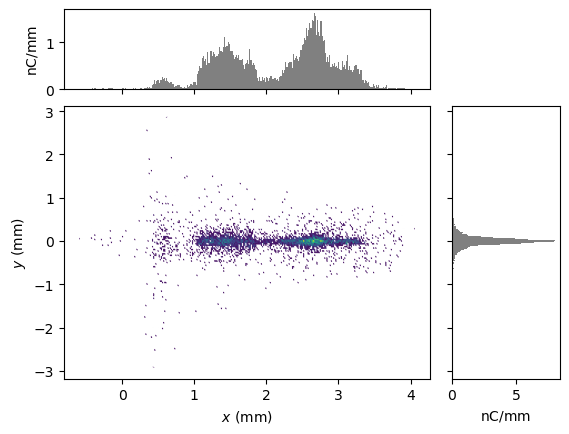

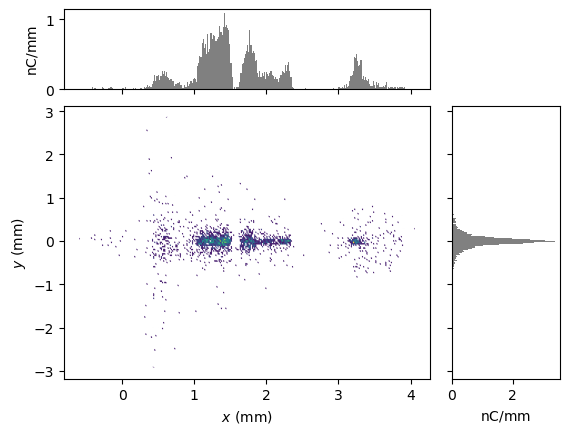

In [7]:
makeBeamActiveBeamFile(PCollimated)
tao.cmd('reinit beam')

trackBeam(tao, trackStart = "CN2069", trackEnd = "end", verbose = True)
P_mod_comparison = getBeamAtElement(tao, comparisonElement)

display(plotMod(P_baseline_comparison, 'x', 'y',  bins=300))
display(plotMod(P_mod_comparison, 'x', 'y',  bins=300))
plt.clf()

In [11]:
filePathGlobal = os.getcwd()


def trackBeamUPGRADE(
    tao,
    trackStart = "L0AFEND",
    trackEnd = "end",
    laserHeater = False,
    centerBC14 = False,
    centerBC20 = False,
    allCollimatorRules = None,
    verbose = False,
    **kwargs,
):
    global filePathGlobal

    #For backwards compatibility, want this function to leave activeBeamFile unmodified
    #Introducing patchBeamFile for piecewise tracking
    #Note that, although initializeTao() asks for inputBeamFilePathSuffix, it will /always/ write it to activeBeamFile


    #Having second thoughts about this. Might be excessively paranoid?
    #shutil.copy(f'{filePathGlobal}/beams/activeBeamFile.h5', f'{filePathGlobal}/beams/patchBeamFile.h5') 
    #tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/patchBeamFile.h5')
    #tao.cmd('reinit beam')

    #Instead, stick with always starting with activeBeamFile?
    tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/activeBeamFile.h5')
    tao.cmd('reinit beam')
    if verbose: print("Loaded activeBeamFile.h5")
    
    tao.cmd(f'set beam_init track_start = {trackStart}')
    tao.cmd(f'set beam_init track_end = {trackEnd}')
    if verbose: print(f"Set track_start = {trackStart}, track_end = {trackEnd}")

    
    if laserHeater:
        #Will track from start to HTRUNDF, get the beam, modify it, export it, import it, update track_start and track_end
        tao.cmd(f'set beam_init track_end = HTRUNDF')
        if verbose: print(f"Set track_end = HTRUNDF")
        
        if verbose: print(f"Tracking!")
        trackBeamHelper(tao)

        P = getBeamAtElement(tao, "HTRUNDF", tToZ = False)

        PAfterLHmodulation, deltagamma, t = addLHmodulation(P, **kwargs,);
        
        writeBeam(PAfterLHmodulation, f'{filePathGlobal}/beams/patchBeamFile.h5')
        if verbose: print(f"Beam with LH modulation written to patchBeamFile.h5")

        tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/patchBeamFile.h5')
        tao.cmd('reinit beam')
        if verbose: print("Loaded patchBeamFile.h5")

        tao.cmd(f'set beam_init track_start = HTRUNDF')
        tao.cmd(f'set beam_init track_end = {trackEnd}')
        if verbose: print(f"Set track_start = HTRUNDF, track_end = {trackEnd}")

    if centerBC14:
        tao.cmd(f'set beam_init track_end = BEGBC14_1')
        if verbose: print(f"Set track_end = BEGBC14_1")

        if verbose: print(f"Tracking!")
        trackBeamHelper(tao)

        P = getBeamAtElement(tao, "BEGBC14_1", tToZ = False)

        PMod = centerBeam(P)
        
        writeBeam(PMod, f'{filePathGlobal}/beams/patchBeamFile.h5')
        if verbose: print(f"Beam centered at BEGBC14 written to patchBeamFile.h5")

        tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/patchBeamFile.h5')
        tao.cmd('reinit beam')
        if verbose: print("Loaded patchBeamFile.h5")

        tao.cmd(f'set beam_init track_start = BEGBC14_1')
        tao.cmd(f'set beam_init track_end = {trackEnd}')
        if verbose: print(f"Set track_start = BEGBC14_1, track_end = {trackEnd}")

    if centerBC20:
        tao.cmd(f'set beam_init track_end = BEGBC20')
        if verbose: print(f"Set track_end = BEGBC20")

        if verbose: print(f"Tracking!")
        trackBeamHelper(tao)

        P = getBeamAtElement(tao, "BEGBC20", tToZ = False)

        PMod = centerBeam(P)
        
        writeBeam(PMod, f'{filePathGlobal}/beams/patchBeamFile.h5')
        if verbose: print(f"Beam centered at BEGBC20 written to patchBeamFile.h5")

        tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/patchBeamFile.h5')
        tao.cmd('reinit beam')
        if verbose: print("Loaded patchBeamFile.h5")

        tao.cmd(f'set beam_init track_start = BEGBC20')
        tao.cmd(f'set beam_init track_end = {trackEnd}')
        if verbose: print(f"Set track_start = BEGBC20, track_end = {trackEnd}")


    if allCollimatorRules:
        tao.cmd(f'set beam_init track_end = CN2069')
        if verbose: print(f"Set track_end = CN2069")

        if verbose: print(f"Tracking!")
        trackBeamHelper(tao)

        P = getBeamAtElement(tao, "CN2069", tToZ = False)

        PMod = collimateBeam(P, allCollimatorRules)
        
        writeBeam(PMod, f'{filePathGlobal}/beams/patchBeamFile.h5')
        if verbose: print(f"Collimated beam written to patchBeamFile.h5. Rules: {allCollimatorRules}")

        tao.cmd(f'set beam_init position_file={filePathGlobal}/beams/patchBeamFile.h5')
        tao.cmd('reinit beam')
        if verbose: print("Loaded patchBeamFile.h5")

        tao.cmd(f'set beam_init track_start = CN2069')
        tao.cmd(f'set beam_init track_end = {trackEnd}')
        if verbose: print(f"Set track_start = CN2069, track_end = {trackEnd}")

    if verbose: print(f"Tracking!")
    trackBeamHelper(tao)

    if verbose: print(f"trackBeam() exiting")

In [12]:
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao


RuntimeError: Command: reinit tao -clear -init /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/bmad/models/f2_elec/tao.init -noplot causes error: ERROR detected: [ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 x": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 px": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 y": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 py": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 t": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 pz": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 p0c": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 charge": BEAM NOT SAVED AT ELEMENT.
INVALID
[ERROR | 2024-OCT-28 10:38:52] tao_python_cmd:
    "python bunch1 BEGBC14_1|model 1 state": BEAM NOT SAVED AT ELEMENT.
INVALID
[INFO] tao_command:
    Reinitializing with: /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/bmad/models/f2_elec/tao.init
[MESSAGE | 2024-OCT-28 10:39:52] tao_init:
    OpenMP active with number of threads: 10
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_BC1"
    FOR VARIABLE: BC_angle
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_BC2"
    FOR VARIABLE: BC_angle
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L1_FUDGE"
    FOR VARIABLE: linac_fudge
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L2_FUDGE"
    FOR VARIABLE: linac_fudge
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L3_FUDGE"
    FOR VARIABLE: linac_fudge
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L1"
    FOR VARIABLE: linac
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_K21_2"
    FOR VARIABLE: linac
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L2"
    FOR VARIABLE: linac
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "O_L3"
    FOR VARIABLE: linac
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "Q50Q3"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "Q4"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "Q5"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "Q6"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "QA0"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "QEM1"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "QEM2"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "QEM3"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_var_stuffit2:
    CANNOT FIND LATTICE ELEMENT WITH NAME: "QEM4"
    FOR VARIABLE: qm_LTUH
[WARNING] tao_init_data:
    LATTICE ELEMENT NOT LOCATED: CE11345
    FOR DATUM: rel_floor.x
    WILL MARK THIS DATUM AS NOT EXISTING
[WARNING] tao_init_data:
    Note: All datums in: BC11C.offset
    are marked as non-existent
[WARNING] tao_init_data:
    NO ELEMENTS FOUND IN SEARCH FOR: MONITOR::YAG*,MONITOR::OTR*
    WHILE SETTING UP DATA ARRAY: orbit.profx
[WARNING] tao_init_data:
    NO ELEMENTS FOUND IN SEARCH FOR: MONITOR::YAG*,MONITOR::OTR*
    WHILE SETTING UP DATA ARRAY: orbit.profy
[WARNING] tao_init_plotting:
    CURVE OF PLOT: energy2
    HAS UNIVERSE INDEX OUT OF RANGE: 2
    IN FILE: $FACET2_LATTICE/bmad/tao/tao_plot.init
[WARNING] tao_init_plotting:
    CURVE OF PLOT: beta2
    HAS UNIVERSE INDEX OUT OF RANGE: 2
    IN FILE: $FACET2_LATTICE/bmad/tao/tao_plot.init
[WARNING] tao_init_plotting:
    CURVE OF PLOT: beta2
    HAS UNIVERSE INDEX OUT OF RANGE: 2
    IN FILE: $FACET2_LATTICE/bmad/tao/tao_plot.init
[INFO] tao_init:
    Note: Radiation fluctuations (but not necessarily damping) are always turned off for single particle tracking...
Using startup file: /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/bmad/tao/tao.startup

Tao: quiet
[WARNING] tao_command:
    The "quiet" command has been replaced by the "set global quiet = <action>" command.

Tao: !-------- tao.startup : commands to execute after initilaization ----

Tao: !veto data *

Tao: veto var *
  begtwiss[1:6]                                  Using:
  q_MRK0F[1:6]                                   Using:
  q_BC11C[1:8]                                   Using:
  q_BC14E[1:9]                                   Using:
  BC_angle[1:2]                                  Using:
  linac_fudge[1:3]                               Using:
  linac[1:4]                                     Using:
  qm_LTUH[1:9]                                   Using:

Tao: set universe * on

Tao: !---Aliases

Tao: alias vim sp vim [[1]]

Tao: ! legacy view command

Tao: alias view set default uni = [[1]]

Tao: alias vv veto var *

Tao: alias vd veto dat *@*

Tao: alias vk set var *|key_bound = F

Tao: alias uv use var

Tao: alias ud use dat

Tao: alias ode set global optimizer = de

Tao: alias olm set global optimizer = lm

Tao: alias osvd set global optimizer = svd

Tao: alias olmdif set global optimizer = lmdif

Tao: alias ogeo set global optimizer = geodesic_lm

Tao: alias sgeo set geodesic_lm

Tao: set geodesic_lm print_level = 2

Tao: alias scycles set global n_opti_cycles = [[1]]

Tao: alias sloops  set global n_opti_loops = [[1]]

Tao: alias sde     set global de_lm_step_ratio = [[1]]

Tao: alias spop set global de_var_to_population_factor = [[1]]

Tao: alias SLD set lattice model=design

Tao: alias sfloor set graph floor.plan floor_plan_view = [[1]]

Tao: alias sr56 set curve r56_compaction.r56_compaction.c1 ele_ref_name = [[1]]

Tao: alias st166  set curve t166.x.c1 ele_ref_name= [[1]]

Tao: alias st566  set curve t566.x.c1 ele_ref_name = [[1]]

Tao: alias su1666 set curve u1666.x.c1 ele_ref_name = [[1]]

Tao: alias su5666 set curve u5666.z.c1 ele_ref_name = [[1]]

Tao: alias sxpx  set curve xphase.x.c1 ele_ref_name =  [[1]]

Tao: alias szpx  set curve zpxphase.x.c1 ele_ref_name = [[1]]

Tao: alias sypy  set curve yphase.y.c1 ele_ref_name = [[1]]

Tao: alias szpz  set curve zphase.z.c1 ele_ref_name = [[1]]

Tao: alias sdispersionx2 set curve dispersionx.x.c2 ele_ref_name = [[1]]

Tao: alias sdispersionxscaled2 set curve dispersionxscaled.x.c2 ele_ref_name = [[1]]

Tao: alias stof1 set curve tof.z.c1 ele_ref_name = [[1]]

Tao: alias stof2 set curve tof.z.c2 ele_ref_name = [[1]]

Tao: alias stofscaled1 set curve tofscaled.z.c1 ele_ref_name = [[1]]

Tao: alias stofscaled2 set curve tofscaled.z.c2 ele_ref_name = [[1]]

Tao: alias beamoff set global track_type = single

Tao: alias beamon set global track_type = beam

Tao: alias snparticle set beam_init n_particle = [[1]]

Tao: alias sbeam_sig_e set beam_init sig_e =  [[1]]

Tao: alias sbeam set beam_init

Tao: alias timeron  set global beam_timer_on = true

Tao: alias timeroff  set global beam_timer_on = false

Tao: alias plotoff set global plot_on = false

Tao: alias ploton set global plot_on = true

Tao: alias clearplots place floor none;place top none;place middle none;place bottom none

Tao: alias phaseplots place r11 zphase;place r12 xphase;place r21 zhist;place r22 yphase;place bottom layout

Tao: alias mat6on  set universe * mat6_recalc on

Tao: alias mat6off set universe * mat6_recalc off

Tao: alias shoval show value ele::[[1]]

Tao: alias outputzphase output curve zphase.z.c1

Tao: alias writetwiss show -write lat.twiss lattice -no_label_lines -custom showtwiss.init

Tao: alias quad_label  set lat_layout ele_shape(1)%label = [[1]]

Tao: alias sbend_label set lat_layout ele_shape(2)%label = [[1]]

Tao: alias lcavity_label set lat_layout ele_shape(3)%label = [[1]]

Tao: alias marker_label set lat_layout  ele_shape(17)%label = [[1]]

Tao: alias monitor_label set lat_layout ele_shape(18)%label = [[1]]

Tao: alias wbeam write beam -at [[1]] [[1]].h5

Tao: x-a all s

Tao: sc

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Set track_end = CN2069
Tracking!
[-0.002, -0.0015]
New particle count: 8679
8679
[-0.0011, -0.001]
New particle count: 8377
8377
Collimated beam written to patchBeamFile.h5. Rules: [[-0.002, -0.0015], [-0.0011,

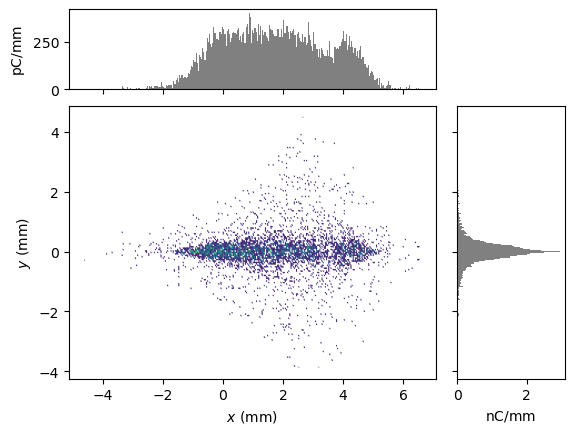

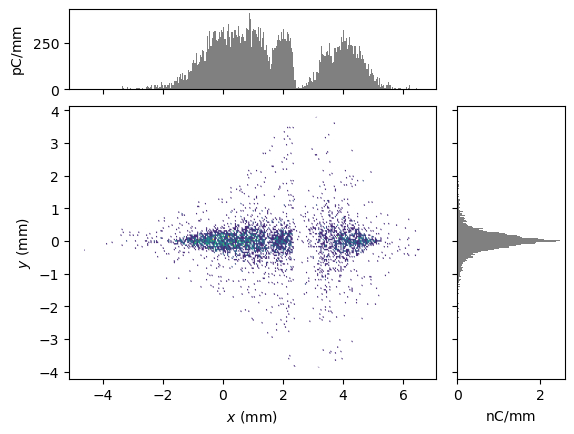

In [13]:
trackBeamUPGRADE(tao, verbose = True, centerBC14=True, centerBC20=True)

P_baseline_comparison = getBeamAtElement(tao, comparisonElement)

trackBeamUPGRADE(tao, verbose = True, centerBC14=True, centerBC20=True, allCollimatorRules = [[-0.002, -0.0015], [-0.0011, -0.001]] )

P_mod_comparison = getBeamAtElement(tao, comparisonElement)

display(plotMod(P_baseline_comparison, 'x', 'y',  bins=300))
display(plotMod(P_mod_comparison, 'x', 'y',  bins=300))
plt.clf()